# Exploratory analysis

## Looking at our data

In [1]:
import torch
from node2vec import Node2Vec
from torch_geometric.data import Data
from utils.gsn_argparse import str2bool, str2actication
import torch_geometric.utils as gutils
from torch_geometric.nn import GAE
import trainer
import utils.gsn_argparse as gap
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Label encoding

In [2]:
# Read data and make dataframes
name = ['entity', 'id']
entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=name, engine='python')
all_entities = entity_id['entity'].values

name = ['relation', 'id']
relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=name, engine='python')
all_relations = relation_id['relation'].values

# Read RDF Triples
name = ['subject', 'object', 'relation']
# concat all data 
train = pd.read_csv('./data/FB15k/train.txt', sep='\t', header=None, names=name, engine='python')
valid = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=name, engine='python')
test = pd.read_csv('./data/FB15k/test.txt', sep='\t', header=None, names=name, engine='python')
data = pd.concat([train, valid])
data = pd.concat([data, test])

In [3]:
data = pd.concat([train, valid])
data = pd.concat([data, test])

In [4]:
# building a relation tree
rels = data['relation']
rels = sorted(rels.values)

In [5]:
rels

['/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/position',
 '/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/team',
 '/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/coach',
 '/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/team',
 '/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/team',
 '/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/team',
 '/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/team',
 '/american_football/football_coach_position/coaches_holding_this_position./american_fo

In [6]:
medicine = []
for el in rels:
    if (el.startswith("/law")):
        medicine.append(el)

In [7]:
medicine = list(set(medicine))

In [8]:
medicine

['/law/judge/courts./law/judicial_tenure/court',
 '/law/invention/inventor',
 '/law/inventor/inventions',
 '/law/court/judges./law/judicial_tenure/judge']

In [9]:
medicine[0].split("/")

['', 'law', 'judge', 'courts.', 'law', 'judicial_tenure', 'court']

In [10]:
med_dict = {}
for entry in medicine:
    tokens = entry.split("/")[2:]
    if tokens[0] in med_dict:
        med_dict[tokens[0]].append(tokens[1])
    else:
        med_dict[tokens[0]] = [tokens[1]]

In [11]:
med_dict

{'judge': ['courts.'],
 'invention': ['inventor'],
 'inventor': ['inventions'],
 'court': ['judges.']}

In [12]:
G = nx.DiGraph()

#add top level
root = "medicine"
for key in med_dict.keys():
    G.add_edge(root, key)
    for child in med_dict[key]:
        G.add_edge(key, child)
G

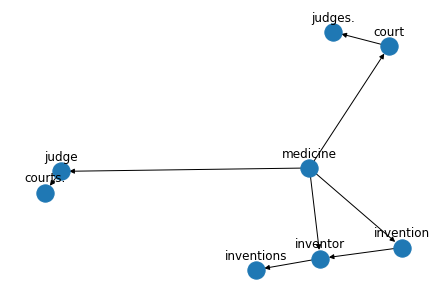

In [13]:
import networkx as nx


pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.1
nx.draw_networkx_labels(G, pos)
plt.show();

In [15]:
print(train.shape)
print(valid.shape)
print(test.shape)
data.shape

(483142, 3)
(50000, 3)
(59071, 3)


(592213, 3)

In [16]:
subjects = data['subject'].values
objects = data['object'].values
relations = data['relation'].values

In [17]:
# fit entity encoder
le_entity = LabelEncoder()
le_entity.fit(all_entities)

# fit relationship encoder
le_relation = LabelEncoder()
le_relation.fit(all_relations)

# string list to int array using LabelEncoder on complete data set
subjects = le_entity.transform(subjects)
objects = le_entity.transform(objects)
relations = le_relation.transform(relations)

# encode subsample (change range to 0-N)
le_entity2 = LabelEncoder().fit(np.append(subjects,objects))
le_relation2 = LabelEncoder().fit(relations)


subjects = le_entity2.transform(subjects)
objects = le_entity2.transform(objects)
relations = le_relation2.transform(relations)


edge_attributes = torch.tensor(relations, dtype=torch.float)
edge_index = torch.tensor([subjects, objects], dtype=torch.long)
unique_entities = torch.tensor(np.unique(edge_index.reshape(edge_index.shape[-1]*2, 1)), dtype=torch.float)
dataset = Data(x=unique_entities, edge_attr=edge_attributes, edge_index=edge_index)

In [18]:
from gensim.models import KeyedVectors
embedded_nodes =  KeyedVectors.load_word2vec_format('embeddings/node_embedding.kv')

In [19]:
dataset.x = torch.tensor(embedded_nodes.vectors, dtype=torch.float)
print(dataset)

Data(edge_attr=[592213], edge_index=[2, 592213], x=[14951, 16])


In [20]:
data = dataset
data.edge_type = torch.LongTensor(relations) #torch.zeros(((data.edge_index.size(-1)),)).long()
data.batch = torch.zeros((1, data.num_nodes), dtype=torch.int64).view(-1)
data.num_graphs = 1
num_features = dataset.x.shape[-1] 
relation_dimension = len(np.unique(relations))
print(f"no. unique relations: {relation_dimension}")
print(f"no. edge_type size: {data.edge_type.size()}")
print(f"no. relation size: {relations.shape}")
print(f"edge_index size: {data.edge_index.size()}")
print(f"min: {np.min(relations)}")
print(f"min: {np.max(relations)}")

no. unique relations: 1345
no. edge_type size: torch.Size([592213])
no. relation size: (592213,)
edge_index size: torch.Size([2, 592213])
min: 0
min: 1344


In [70]:
def load():
    # Read data and make dataframes
    name = ['entity', 'id']
    entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=name, engine='python')
    all_entities = entity_id['entity'].values

    name = ['relation', 'id']
    relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=name, engine='python')
    all_relations = relation_id['relation'].values

    # Read RDF Triples
    # Read RDF Triples
    name = ['head', 'relation', 'tail']
    # concat all data 
    train = pd.read_csv('./data/FB15k/train.txt', sep='\t', header=None, names=name, engine='python')
    valid = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=name, engine='python')
    test = pd.read_csv('./data/FB15k/test.txt', sep='\t', header=None, names=name, engine='python')
    data = pd.concat([train, valid])
    data = pd.concat([data, test])

    head = data['head'].values
    tail = data['tail'].values
    relations = data['relation'].values
    
    # fit entity encoder
    le_entity = LabelEncoder()
    le_entity.fit(all_entities)

    # fit relationship encoder
    le_relation = LabelEncoder()
    le_relation.fit(all_relations.reshape(-1, 1))

    # string list to int array using LabelEncoder on complete data set
    heads = le_entity.transform(head)
    tails = le_entity.transform(tail)
    relations = le_relation.transform(relations)
    all_relations = le_relation.transform(all_relations.reshape(-1, 1))
    
    edge_attributes = torch.tensor(relations, dtype=torch.long)
    edge_index = torch.tensor([heads, tails], dtype=torch.long)
    unique_entities = torch.tensor(np.unique(edge_index.reshape(edge_index.shape[-1]*2, 1)), dtype=torch.float)

    dataset =  Data(x=unique_entities, edge_type=edge_attributes, edge_index=edge_index)
    
    from gensim.models import KeyedVectors
    embedded_nodes =  KeyedVectors.load_word2vec_format('embeddings/node_embedding.kv')
    dataset.x = torch.tensor(embedded_nodes.vectors, dtype=torch.float)
    print(dataset)
    
    data = dataset
    data.edge_type = torch.LongTensor(relations) #torch.zeros(((data.edge_index.size(-1)),)).long()
    data.batch = torch.zeros((1, data.num_nodes), dtype=torch.int64).view(-1)
    data.num_graphs = 1
    num_features = dataset.x.shape[-1] 
    relation_dimension = len(np.unique(relations))
    print(f"no. unique relations: {relation_dimension}")
    print(f"no. edge_type size: {data.edge_type.size()}")
    print(f"no. relation size: {relations.shape}")
    print(f"edge_index size: {data.edge_index.size()}")
    print(f"min: {np.min(relations)}")
    print(f"min: {np.max(relations)}")
    return data, le_entity, le_entity2, le_relation, le_relation2

In [67]:
def inverse_transform(sub, obj, rel):
    sub = le_entity.inverse_transform(le_entity2.inverse_transform([sub]))
    obj = le_entity.inverse_transform(le_entity2.inverse_transform([obj]))
    rel = le_relation.inverse_transform(le_relation2.inverse_transform([rel]))
    return sub[0], obj[0], rel[0]

In [68]:
inverse_transform(data.edge_index[0][0], data.edge_index[1][0], data.edge_type[0])

AttributeError: 'DataFrame' object has no attribute 'edge_index'

In [24]:
label_dict ={}
for n1, n2, ys in zip(data.edge_index[0], data.edge_index[1], data.edge_type):
    label_dict[int(n1), int(n2)] = int(ys)

In [25]:
def visualize(h, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=True,
                          cmap="Set2")
        nx.draw_networkx_edge_labels(h, pos=nx.spring_layout(h, seed=42), edge_labels=label_dict, cmap="Set2")
    plt.show()

In [26]:
from torch_geometric.utils import to_networkx
G = to_networkx(dataset)

AttributeError: 'int' object has no attribute 'squeeze'

In [ ]:
print(G.number_of_nodes())
print(dataset.num_nodes)

In [ ]:
%matplotlib notebook
if len(unique_entities) > 200:
    print("you should probably not visualize huge node networks")
else:
    visualize(G) 

In [34]:
#!pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def freebase_parser(freebase_id):
    endpoint_url = "https://query.wikidata.org/sparql"

    query = \
    '''SELECT ?sLabel WHERE { 
        ?s wdt:P646 "''' + freebase_id + '''".
        SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1'''
    res = get_results(endpoint_url, query)
    if len(res['results']['bindings']) == 0:
        return "No result"
    else:
        return get_results(endpoint_url, query)['results']['bindings'][0]['sLabel']['value']
    
def rdf2txt(sub, obj, rel):
    sub, obj, rel = inverse_transform(sub,obj,rel)
    sub = freebase_parser(sub)
    obj = freebase_parser(obj)
    return sub, obj, str(rel)

In [35]:
def rdf2txt(sub, obj, rel):
    sub, obj, rel = inverse_transform(sub,obj,rel)
    sub = freebase_parser(sub)
    obj = freebase_parser(obj)
    return sub, obj, str(rel)

In [36]:
rdf2txt(23, 2, 46)

('Morgantown',
 'Marshall',
 '/architecture/structure/owner./architecture/ownership/owner')

In [42]:
G

## Node2Vec

In [37]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=20, workers=1)  # Use temp_folder for big graphs

Generating walks (CPU: 1): 100%|█████████████████████████████████| 20/20 [00:00<00:00, 1176.77it/s]


In [38]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  
# Any keywords acceptable by gensim.Word2Vec can be passed, 
# `dimensions` and `workers` are automatically passed
# (from the Node2Vec constructor)

In [39]:
def node2Text(node_id):
    freebase_id = le_entity.inverse_transform(le_entity2.inverse_transform([node_id]))
    return freebase_parser(freebase_id[0])

In [40]:
# Look for most similar nodes
NODE_ID = '2'
print(f"Most similar Nodes to {node2Text(int(NODE_ID))}")
for node in model.wv.most_similar(NODE_ID):
    sim_node_id, percentage = node
    print(node2Text(int(sim_node_id)), percentage) 

Most similar Nodes to Marshall


KeyError: "word '2' not in vocabulary"

In [ ]:
# Save embeddings for later use
import os
PATH = 'embeddings'
NODE_EMBEDDING_NAME = "node_embedding"
EMBEDDING_MODEL_NAME = "node_embedding_model"
if not os.path.exists(PATH):
    os.mkdir(PATH)
model.wv.save_word2vec_format(os.path.join(PATH, NODE_EMBEDDING_NAME + ".kv"))

In [41]:
# Save model for later use
model.save(os.path.join(PATH, EMBEDDING_MODEL_NAME + ".pkl"))

NameError: name 'os' is not defined

In [ ]:
from gensim.models import KeyedVectors
embedded_nodes =  KeyedVectors.load_word2vec_format('embeddings/node_embedding.kv')


In [ ]:
# Load embeddings 
embeddings = model.wv.load_word2vec_format(os.path.join(PATH, NODE_EMBEDDING_NAME + ".kv"))
embedded_model = model.wv.load(os.path.join(PATH, EMBEDDING_MODEL_NAME + ".pkl"))

In [ ]:
# Look for most similar nodes
NODE_ID = '2'
print(f"Most similar Nodes to {node2Text(int(NODE_ID))}")
for node in embedded_model.wv.most_similar(NODE_ID):
    sim_node_id, percentage = node
    print(node2Text(int(sim_node_id)), percentage) 

In [ ]:
embedded_x = torch.tensor(embeddings.vectors, dtype=torch.float)

In [ ]:
dataset.edge_index = torch.stack([row, col], dim=0)

In [ ]:
data = GAE.split_edges(GAE, dataset)

In [ ]:
l1 = data.test_pos_edge_index[0][0]
l2 = data.test_pos_edge_index[1][0]

In [ ]:
print(dataset.edge_index[0].tolist().index(l1))
print(dataset.edge_index[1].tolist().index(l2))

In [ ]:
dataset

In [27]:
y[np.where(dataset.edge_index.T == torch.tensor([5217, 10644]))[0]]

NameError: name 'y' is not defined

In [28]:
import math as m

entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=['entity', 'id'], engine='python')
entity = entity_id['entity'].values

relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=['relation', 'id'], engine='python')
relation = relation_id['relation'].values

data = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=['subject', 'object', 'relation'], engine='python')
print('\tLoading FB15k training (valid file) data...')

dataset = label_encode_dataset(entity, relation, data)

# create node embeddings if none exists
if not os.path.exists("embeddings"):
    create_node_embedding(dataset)
embedded_nodes =  KeyedVectors.load_word2vec_format('embeddings/node_embedding.kv')

dataset.x = torch.tensor(embedded_nodes.vectors, dtype=torch.float)
data = GAE.split_edges(GAE, dataset)

	Loading FB15k training (valid file) data...


NameError: name 'label_encode_dataset' is not defined

In [ ]:
print(dataset)
full_length = dataset.edge_index.shape[-1]
train_index = torch.tensor(dataset.edge_index[:, 0:m.floor(full_length*0.7)], dtype=torch.long)
train_attr_index = torch.tensor(dataset.edge_attr[0:m.floor(full_length*0.7)], dtype=torch.long)

val_index = torch.tensor(dataset.edge_index[:, m.floor(full_length*0.7):m.floor(full_length*0.9)], dtype=torch.long)
val_attr_index = torch.tensor(dataset.edge_attr[m.floor(full_length*0.7):m.floor(full_length*0.9)], dtype=torch.long)

test_index = torch.tensor(dataset.edge_index[:, m.floor(full_length*0.9):], dtype=torch.long)
test_attr_index = torch.tensor(dataset.edge_attr[m.floor(full_length*0.9):], dtype=torch.long)



dataset.edge_index = torch.cat([train_index, val_index, test_index], dim=1)
dataset.edge_attr = torch.cat([train_attr_index, val_attr_index, test_attr_index])

dataset.edge_train_mask = torch.cat([torch.ones((train_index.size(-1))),
                                  torch.zeros((val_index.size(-1))),
                                  torch.zeros((test_index.size(-1)))], dim=0).byte()
dataset.edge_val_mask = torch.cat([torch.zeros((train_index.size(-1))),
                                torch.ones((val_index.size(-1))),
                                torch.zeros((test_index.size(-1)))], dim=0).byte()
dataset.edge_test_mask = torch.cat([torch.zeros((train_index.size(-1))),
                                 torch.zeros((val_index.size(-1))),
                                 torch.ones((test_index.size(-1)))], dim=0).byte()

dataset.edge_train_attr_mask = torch.cat([torch.ones((train_attr_index.size(-1))),
                                  torch.zeros((val_attr_index.size(-1))),
                                  torch.zeros((test_attr_index.size(-1)))], dim=0).byte()
dataset.edge_val_attr_mask = torch.cat([torch.zeros((train_attr_index.size(-1))),
                                torch.ones((val_attr_index.size(-1))),
                                torch.zeros((test_attr_index.size(-1)))], dim=0).byte()
dataset.edge_test_attr_mask = torch.cat([torch.zeros((train_attr_index.size(-1))),
                                 torch.zeros((val_attr_index.size(-1))),
                                 torch.ones((test_attr_index.size(-1)))], dim=0).byte()

dataset.edge_type = torch.zeros(((dataset.edge_index.size(-1)),)).long()

dataset.batch = torch.zeros((1, dataset.num_nodes), dtype=torch.int64).view(-1)
dataset.num_graphs = 1
num_features = dataset.x.shape[-1] 
num_relations = max(np.unique(dataset.edge_attr)) + 1

In [29]:
np.where(dataset.edge_index.T == data.val_pos_edge_index.T[0])[0]

AttributeError: 'DataFrame' object has no attribute 'val_pos_edge_index'

In [30]:
pair = dataset.val_pos_edge_index.T[0]
obj = pair[1]
sub = pair[0]
rel = np.where(dataset.edge_index.T == data.val_pos_edge_index.T[0])[0]
print(obj, sub, rel)

AttributeError: 'Data' object has no attribute 'val_pos_edge_index'

In [31]:
rdf2txt(int(sub), int(obj), int(y[rel]))

NameError: name 'rdf2txt' is not defined

In [32]:
dataset.edge_attr[4877]

tensor(100.)

In [33]:
rdf2txt(8937, 4141, 341)

NameError: name 'rdf2txt' is not defined

In [ ]:
from torch_geometric.utils import to_networkx
from node2vec import Node2Vec
import os

def make_node_embeddings(dataset, path="embeddings", node_embedding_name="node_embeddings", embedding_model_name="node_embedding_model", dimensions=16, walk_length=15, num_walks=20, workers=1, window=10, min_count=1, batch_words=4):
    G = to_networkx(dataset)
   
    # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)  # Use temp_folder for big graphs
    
    # Embed nodes
    model = node2vec.fit(window=window, min_count=min_count, batch_words=batch_words)  # Any keywords acceptable by gensim.Word2Vec can be passed, 
                                                                 # `dimensions` and `workers` are automatically passed
                                                                 # (from the Node2Vec constructor)
    
    # Save embeddings for later use
    if not os.path.exists(path):
        os.mkdir(path)
    model.wv.save_word2vec_format(os.path.join(path, node_embedding_name + ".kv"))
    model.save(os.path.join(path, embedding_model_name + ".pkl"))
    print(f"Saved embedding and model in the {path} folder")
    return model.vw.vectors

## Evaluating Graph Star Multi Relational

In [44]:
import torch
model = torch.load("output/idun.pkl", map_location=torch.device('cpu'))

In [45]:
model

GraphStar(
  (fl): Linear(in_features=16, out_features=256, bias=True)
  (star_init): StarAttn(
    (Wq): Linear(in_features=256, out_features=256, bias=True)
    (Wk): Linear(in_features=256, out_features=256, bias=True)
    (Wv): Linear(in_features=256, out_features=256, bias=True)
    (sLayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (conv_list): ModuleList(
    (0): GraphStarConv(256, 256, heads=4)
    (1): GraphStarConv(256, 256, heads=4)
    (2): GraphStarConv(256, 256, heads=4)
  )
  (star_attn_list): ModuleList(
    (0): StarAttn(
      (Wq): Linear(in_features=256, out_features=256, bias=True)
      (Wk): Linear(in_features=256, out_features=256, bias=True)
      (Wv): Linear(in_features=256, out_features=256, bias=True)
      (sLayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): StarAttn(
      (Wq): Linear(in_features=256, out_features=256, bias=True)
      (Wk): Linear(in_features=256, out_features=256, bias=True)
      (

In [190]:
# Read data and make dataframes
name = ['entity', 'id']
entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=name, engine='python')
all_entities = entity_id['entity'].values

name = ['relation', 'id']
relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=name, engine='python')
all_relations = relation_id['relation'].values

# Read RDF Triples
name = ['head', 'tail', 'relation']
# concat all data 
train = pd.read_csv('./data/FB15k/train.txt', sep='\t', header=None, names=name, engine='python')
valid = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=name, engine='python')
test = pd.read_csv('./data/FB15k/test.txt', sep='\t', header=None, names=name, engine='python')
data = pd.concat([train, valid])
data = pd.concat([data, test])

In [191]:
head = data['head'].values
tail = data['tail'].values
relations = data['relation'].values

# fit entity encoder
le_entity = LabelEncoder()
le_entity.fit(all_entities)

# fit relationship encoder
le_relation = LabelEncoder()
le_relation.fit(all_relations.reshape(-1, 1))

# string list to int array using LabelEncoder on complete data set
heads = le_entity.transform(head)
tails = le_entity.transform(tail)
relations = le_relation.transform(relations)

edge_attributes = torch.tensor(relations, dtype=torch.long)
edge_index = torch.tensor([heads, tails], dtype=torch.long)
unique_entities = torch.tensor(np.unique(edge_index.reshape(edge_index.shape[-1]*2, 1)), dtype=torch.float)

dataset = Data(x=unique_entities, edge_type=edge_attributes, edge_index=edge_index)

In [195]:
#!pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def freebase_parser(freebase_id):
    endpoint_url = "https://query.wikidata.org/sparql"

    query = \
    '''SELECT ?sLabel WHERE { 
        ?s wdt:P646 "''' + freebase_id + '''".
        SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1'''
    res = get_results(endpoint_url, query)
    if len(res['results']['bindings']) == 0:
        return "No result"
    else:
        return get_results(endpoint_url, query)['results']['bindings'][0]['sLabel']['value']
    
    
def inverse_transform(head, tail, rel):
    head = le_entity.inverse_transform([head])
    tail = le_entity.inverse_transform([tail])
    rel = le_relation.inverse_transform([rel])
    return head[0], tail[0], rel[0]


def rdf2txt(head, tail, rel):
    head, tail, rel = inverse_transform(head, tail, rel)
    head = freebase_parser(head)
    tail = freebase_parser(tail)
    return head, tail, str(rel)

In [200]:
# Logits embedding [13292, 256] -> [unique nodes x hidden layer]
index = 136
z = model.z
# Edge index between 2 nodes
edge_index = dataset.edge_index.T[index].T
# relation type
edge_type = dataset.edge_type[index]

In [201]:
rdf2txt(edge_index[0], edge_index[1], edge_type)

('Kaneto Shiozawa', 'Japan', '/people/person/nationality')

In [202]:
z2 = torch.sigmoid(z)

In [203]:
head = z2[edge_index[0]]
relation =  model.RW[edge_type]
tail = z2

In [204]:
# SCORING FUNCTION
p = head*relation*tail
score = torch.sigmoid(p.sum(dim=-1))

In [205]:
pred = score.detach().numpy().argsort()[-10:][::-1]

In [219]:
def pred(head=True, index=0, sig=True, emb_sig=True):
    emb = z
    if emb_sig:
        emb = z2
    edge_index = dataset.edge_index.T[index].T
    edge_type = dataset.edge_type[index]
    
    h, t, r = rdf2txt(edge_index[0], edge_index[1], edge_type)
    relation =  model.RW[edge_type]
    if head:
        out_text = "predicted heads:"
        head = emb
        tail = emb[edge_index[1]]
    else:
        out_text = "predicted tails:"
        head = emb[edge_index[0]]
        tail = emb

    p = head*relation*tail
    score = p.sum(dim=-1)
    if sig:
        score = torch.sigmoid(score)
    
    pred = score.detach().numpy().argsort()[-10:][::-1]
    
    print(f"Original h:{h}, r: {r}, t:{t}")
    print("predicted t:")
    for l in pred:
        h, t, r = rdf2txt(edge_index[0], l, edge_type)
        print (t)


In [278]:
b = z[edge_index[0]] * model.RW[edge_type] * z[edge_index[1]]

In [279]:
b.sum()

tensor(-0.5518, grad_fn=<SumBackward0>)

Bra id:
*  355

In [276]:
pred(head=True, index=355, sig=True, emb_sig=False)

Original h:Jack Bruce, r: /music/artist/genre, t:hard rock
predicted t:
Gwar
Chris Thomas King
Gene Simmons
Josh Homme
Mark Knopfler
Muse
Demi Lovato
MGMT
Glenn Frey
Gustavo Cerati


In [187]:
# Logits embedding [13292, 256] -> [unique nodes x hidden layer]
index = 129
z = model.z
# Edge index between 2 nodes
edge_index = dataset.edge_index.T[index].T
# relation type
edge_type = dataset.edge_type[index]
h, t, r = rdf2txt(edge_index[0], edge_index[1], edge_type)
head = z2[edge_index[0]]
relation =  model.RW[edge_type]
tail = z2
# SCORING FUNCTION
p = head*relation*tail
score = torch.sigmoid(p.sum(dim=-1))
pred = score.detach().numpy().argsort()[-10:][::-1]
print(f"Original h:{h}, r: {r}, t:{t}")
print("predicted t:")
for l in pred:
    h, t, r = rdf2txt(edge_index[0], l, edge_type)
    print (t)
# Recall precision on top 10.

Original h:Kaneto Shiozawa, r: /people/profession/people_with_this_profession, t:voice actor
predicted t:
forward
actor
screenwriter
United States of America
visual effects supervisor
executive producer
Academy Award for Best Picture
No result
television producer
make-up artist


In [183]:
# Logits embedding [13292, 256] -> [unique nodes x hidden layer]
z = model.z

def experiment(index=0):
    
    # Edge index between 2 nodes
    edge_index = dataset.edge_index.T[index].T
    # relation type
    edge_type = dataset.edge_type[index]
    
    h, t, r = rdf2txt(edge_index[0], edge_index[1], edge_type)
    print(f" \
        Original data: \n \
        Head: {h} \n \
        Relation: {r} \n \
        Tail: {t} \n")
    
    head = z[edge_index[0]]
    relation =  model.RW[edge_type]
    tail = z
    p = head * relation * tail
    pred = int(round(np.argmax(p.detach().numpy())/256))
    
    h, t, r = rdf2txt(edge_index[0], pred, edge_type)
    print(f" \
        Predicted data: \n \
        Head: {h} \n \
        Relation: {r} \n \
        Tail: {t} \n")

In [117]:
experiment(2859)

         Original data: 
         Head: Werner Herzog 
         Relation: /people/person/profession 
         Tail: film producer 

         Predicted data: 
         Head: Werner Herzog 
         Relation: /people/person/profession 
         Tail: Julie Delpy 



In [ ]:
head = z[edge_index[0]]
relation =  model.RW[edge_type]
tail = z[edge_index[1]]
p = head * relation * tail

In [ ]:
p.sum()

## How to evaluate
All should use top 10 / 5 / 1
*  Zero - One f0-score (does it predict correctly or not)
*  Hierachical correctness (How far up the relationtree ? Does it get film/film or film/film/other_crew)
*  Top-K hits (Is the correct in label in top-K in predictions) (precision, recall, f0)
*  Split relationship and regex in pred relations (finding related relations)

Need to explain hierachical layout of freebase!


## 2 THE LINK PREDICTION PROBLEM
This section provides a detailed outline for the LP task in the context of KGs, introducing key concepts that we are
going to refer to in our work.


  We define a KG as a labeled, directed multi-graph KG = (E, R, G):
* E: a set of nodes representing entities;
* R: a set of labels representing relations;
* G ⊆ E × R × E: a set of edges representing _facts_ connecting pairs of entities. Each fact is a triple _⟨h, r, t⟩_, where
_h_ is the head, _r_ is the relation, and _t_ is the tail of the fact.

In [ ]:
# Logits embedding [13292, 256] -> [unique nodes x hidden layer]
z = model.z
# Edge index between 2 nodes
edge_index = dataset.edge_index.T[5].T
# relation type
edge_type = dataset.edge_type[5]
rdf2txt(edge_index[0], edge_index[1], edge_type)

**Link Prediction** (LP) is the task of exploiting the existing facts in a KG to infer missing ones. This amounts to
guessing the correct entity that completes _⟨h, r, ?⟩_ (tail prediction) or _⟨?, r, t⟩_ (head prediction). For the sake of simplicity, when talking about head and tail prediction globally, we call _source_ entity the known entity in the prediction, and _target_ entity the one to predict.


In the following we use _italic_ letters to identify KG elements (entities or relations), and **bold** letters to identify the
corresponding embeddings. Given for instance a generic entity, we may use _e_ when referring to its element in the
graph, and **e** when referring to its embedding.


Datasets employed in LP research are typically obtained subsampling real-world KGs; each dataset can therefore be
seen as a small KG with its own sets of entities E, relations R and facts G. In order to facilitate research, G is further
split into three disjoint subsets: a training set G_train, a validation set G_valid and a test set G_test.


Most of LP models based on embeddings define a scoring function ϕ to estimate the plausibility of any fact _⟨h, r, t⟩_
using their embeddings:


> ϕ(**h** ,**r**, **t**)


In this paper, unless differently specified, we are going to assume that the higher the score of ϕ, the more plausible the
fact.


During training, embeddings are usually initialized randomly and subsequently improved with optimization algorithms such as back-propagation with gradient descent. The positive samples in G_train are often randomly corrupted
in order to generate negative samples. The optimization process aims at maximizing the plausibility of positive facts as
well as minimizing the plausibility of negative facts; this often amounts to employing a **triplet loss** function. Over time,
more effective ways to generate negative triples have been proposed, such as sampling from a Bernouilli distribution [66] or generating them with adversarial algorithms [55]. In addition to the embeddings of KG elements, models may also
use the same optimization algorithms to learn additional parameters (e.g. the weights of neural layers). Such parameters,
if present, are employed in the scoring function ϕ to process the actual embeddings of entities and relations. Since they
are not specific to any KG element, they are often dubbed _shared parameters_.


In prediction phase, given an incomplete triple _⟨h, r, ?⟩_, the missing tail is inferred as the entity that, completing the
triple, results in the highest score:
> t = argmax_(e∈E) ϕ(**h**, **r**, **e**)

Head prediction is performed analogously.

Evaluation is carried out by performing both head and tail prediction on all test triples in G_test , and computing for
each prediction how the target entity ranks against all the other ones. Ideally, the target entity should yield the highest
plausibility.

Ranks can be computed in two largely different settings, called raw and filtered scenarios. As a matter of fact, a prediction may have multiple valid answers: for instance, when predicting the tail for _⟨ Barack Obama, parent, Natasha Obama ⟩_,
a model may associate a higher score to _Malia Obama_ than to _Natasha Obama_. More generally, if the predicted fact is
contained in G (that is, either in G_train, or in G_valid or in G_test ), the answer is valid. Depending on whether valid
answers should be considered acceptable or not, two separate settings have been devised:

*  _Raw Scenario_: in this scenario, valid entities outscoring the target one are considered as mistakes. Therefore
they do contribute to the rank computation. Given a test fact ⟨h, r, t⟩ ∈ Gtest , the raw rank r_t of the target
tail _t_ is computed as:

> _r_t = |{e ∈ E \ {t } : ϕ(h, r, e) > ϕ(h, r,t)}|_ + 1

The raw rank in head prediction can be computed analogously.

*  _Filtered Scenario_: in this scenario, valid entities outscoring the target one are not considered mistakes. Therefore
they are skipped when computing the rank. Given a test fact _⟨h, r, t⟩ ∈ G_test_ , the filtered rank r_t of the target
tail t is computed as:

> _r_t = |{e ∈ E \ {t } : ϕ(h, r, e) > ϕ(h, r,t) ∧ h h, r, e i < G}|_ + 1

The filtered rank in head prediction can be computed analogously.


In order to compute the rank it is also necessary to define the policy to apply when the target entity obtains the
same score as other ones. This event is called a _tie_ and it can be handled with different policies:

* _min_: the target is given the lowest rank among the entities in tie. This is the most permissive policy, and it may
result in artificially boosting performances: as an extreme example, a model systematically setting the same
score to all entities would obtain perfect results under this policy.
*  _average_: the target is given the average rank among the entities in tie.
*  _random_: the target is given a random rank among the entities in tie. On large test sets, this policy should
globally amount to the average policy.
*  _ordinal_: the entities in tie are given ranks based on the order in which they have been passed to the model.
This usually depends on the internal identifiers of entities, which are independent from their scores: therefore
this policy should globally correspond to the random policy.
*  _max_: the target is given the highest (worst) rank among the entities in tie. This is the most strict policy.

The ranks Q obtained from test predictions are usually employed to compute standard global metrics. The most
commonly employed metrics in LP are:
> _Mean Rank_ (MR). It is the average of the obtained ranks:

\begin{equation*}
MR = \frac{1}{|Q|} \sum_{q\in Q} q
\end{equation*}

It is always between 1 and |E|, and the lower it is, the better the model results. It is very sensitive to outliers, therefore
researchers lately have started avoiding it, resorting to Mean Reciprocal Rank instead.

_Mean Reciprocal Rank_ (MRR). It is the average of the inverse of the obtained ranks:

\begin{equation*}
MRR = \frac{1}{|Q|} \sum_{q\in Q} \frac{1}{q}
\end{equation*}

It is always between 0 and 1, and the higher it is, the beer the model results.


> _Hits@K_ (H@K). It is the ratio of predictions for which the rank is equal or lesser than a threshold _K_:

\begin{equation*}
H@K = \frac{|\{q ∈ Q : q ≤ K\}|}{|Q|}
\end{equation*}

Common values for K are 1, 3, 5, 10. The higher the H@K, the better the model results. In particular, when K = 1, it
measures the ratio of the test facts in which the target was predicted correctly on the first try. H@1 and MRR are often
closely related, because these predictions also correspond to the most relevant addends to the MRR formula.


These metrics can be computed either separately for subsets of predictions (e.g. considering separately head and tail
predictions) or considering all test predictions altogether.

In [ ]:
def distMult(h,r,t):
    return h*r*t


In [ ]:
 def lp_log(self, z, pos_edge_index, pos_edge_type, known_edge_index, known_edge_type):
        dt, dev = pos_edge_index.dtype, pos_edge_index.device
        ranks = []

        # head batch
        for i in range(len(pos_edge_type)):
            pei = torch.stack([torch.arange(0, z.size(0), dtype=dt, device=dev),
                               torch.full((z.size(0),), pos_edge_index[1][i], dtype=dt, device=dev)], dim=0)
            pet = torch.full((z.size(0),), pos_edge_type[i], dtype=dt, device=dev)
            pred = distMult(z, pei, pet)
            rank = (pred >= pred[pos_edge_index[0][i]]).sum().item()

            # filter
            filter_idx = (\
                (known_edge_index[1] == pos_edge_index[1][i]) * (known_edge_type == pos_edge_type[i])\
            ).nonzero().view(-1)
            
            filter_idx = known_edge_index[0][filter_idx]
            rank -= (pred[filter_idx] >= pred[pos_edge_index[0][i]]).sum().item()
            rank += 1
            ranks.append(rank)

        # tail batch
        for i in range(len(pos_edge_type)):
            pei = torch.stack([torch.full((z.size(0),), pos_edge_index[0][i], dtype=dt, device=dev),
                               torch.arange(0, z.size(0), dtype=dt, device=dev)], dim=0)
            pet = torch.full((z.size(0),), pos_edge_type[i], dtype=dt, device=dev)
            pred = self.lp_score(z, pei, pet)

            rank = (pred >= pred[pos_edge_index[1][i]]).sum().item()

            # filter
            filter_idx = ((known_edge_index[0] == pos_edge_index[0][i]) * (
                    known_edge_type == pos_edge_type[i])).nonzero().view(-1)
            filter_idx = known_edge_index[1][filter_idx]
            rank -= (pred[filter_idx] >= pred[pos_edge_index[1][i]]).sum().item()
            rank += 1
            ranks.append(rank)
        ranks = np.array(ranks)

        print("MRR: %f, MR: %f, HIT@1: %f, HIT@3: %f, HIT@10: %f" % (
            (1 / ranks).sum() / len(ranks),
            (ranks).sum() / len(ranks),
            (ranks <= 1).sum() / len(ranks),
            (ranks <= 3).sum() / len(ranks),
            (ranks <= 10).sum() / len(ranks)
        ))

In [ ]:
type(dataset.edge_index)

In [ ]:
dataset.edge_type[12566]

In [ ]:
def shuffle_dataset(dataset):
    df = pd.DataFrame([dataset.edge_index[0], dataset.edge_index[1], dataset.edge_type]).T
    df = df.sample(frac=1)
    edge_attributes = torch.tensor(list(df[2].values), dtype=torch.float)
    edge_index = torch.tensor([list(df[0].values), list(df[1].values)], dtype=torch.long)
    dataset.edge_type = edge_attributes
    dataset.edge_index = edge_index 
    return dataset

In [ ]:
k = pd.DataFrame([dataset.edge_index[0], dataset.edge_index[1], dataset.edge_type]).T

In [ ]:
torch.Tensor(list(k[0].values))

In [ ]:
edge_attributes = torch.tensor(list(k[2].values), dtype=torch.float)
edge_index = torch.tensor([list(k[0].values), list(k[1].values)], dtype=torch.long)

In [ ]:
shuffle_dataset(dataset)

In [ ]:
dataset.edge_type[12566]

In [ ]:
def train_val_test_split(dataset):
    train_size = int(np.floor(dataset.num_nodes*0.7))
    valid_size = int(np.floor(dataset.num_nodes*0.9))
    # edge_indexes
    dataset.train_pos_edge_index = dataset.edge_index.T[0:train_size].T
    dataset.val_pos_edge_index = dataset.edge_index.T[train_size : valid_size].T
    dataset.test_pos_edge_index = dataset.edge_index.T[valid_size:].T
    
   # relations
    dataset.train_edge_type = dataset.edge_type[0:train_size]
    dataset.val_edge_type = dataset.edge_type[train_size : valid_size]
    dataset.test_edge_type = dataset.edge_type[valid_size:]
    
    return dataset

In [ ]:
dataset = train_val_test_split(dataset)

In [ ]:
dataset

In [ ]:
getattr(dataset, 'val_edge_type')

In [ ]:
def negative_sampling(edge_index, num_nodes=None, num_neg_samples=None):
    r"""Samples random negative edges of a graph given by :attr:`edge_index`.

    Args:
        edge_index (LongTensor): The edge indices.
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        num_neg_samples (int, optional): The number of negative samples to
            return. If set to :obj:`None`, will try to return a negative edge
            for every positive edge. (default: :obj:`None`)

    :rtype: LongTensor
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    num_neg_samples = num_neg_samples or edge_index.size(1)

    # Handle '2*|edges| > num_nodes^2' case.
    num_neg_samples = min(num_neg_samples,
                          num_nodes * num_nodes - edge_index.size(1))

    idx = (edge_index[0] * num_nodes + edge_index[1]).to('cpu')

    rng = range(num_nodes**2)
    perm = torch.tensor(random.sample(rng, num_neg_samples))
    mask = torch.from_numpy(np.isin(perm, idx)).to(torch.bool)
    rest = mask.nonzero().view(-1)
    while rest.numel() > 0:  # pragma: no cover
        tmp = torch.tensor(random.sample(rng, rest.size(0)))
        mask = torch.from_numpy(np.isin(tmp, idx)).to(torch.bool)
        perm[rest] = tmp
        rest = rest[mask.nonzero().view(-1)]

    row, col = perm / num_nodes, perm % num_nodes
    return torch.stack([row, col], dim=0).long().to(edge_index.device)

In [ ]:
from torch_geometric.utils import structured_negative_sampling

out = structured_negative_sampling(dataset.val_pos_edge_index)

In [ ]:
torch.tensor([list(out[0]), list(out[2])], dtype=torch.long)


In [ ]:
mode = "train"
cal_mrr_score = True

In [ ]:
if (mode != "train") and cal_mrr_score:
    print("hey")